# Plot qPCR of RNA export by candidate VLP-based exporters

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_VLP_screen"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_VLP_screen_Cq_plate1.csv"

cq_raw_plate1 = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw_plate1.drop(columns_to_drop, axis=1, inplace=True)
cq_raw_plate1.set_index("Well", inplace=True)

print(cq_raw_plate1.shape)
cq_raw_plate1.head()

(90, 12)


,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Well,,,,,,,,,,,,
A01,SYBR,mCherry,Unkn-01,Well1,Supernatant,38.206189,37.511524,0.846699,2.297993,0.361349,3.928858,2.210792
A02,SYBR,mCherry,Unkn-03,Well2,Supernatant,36.933946,36.813837,0.936629,5.119925,0.709264,6.205723,3.679412
A03,SYBR,mCherry,Unkn-05,Well3,Supernatant,34.758167,34.131185,0.559309,20.149498,1.304264,31.089432,9.962593
A04,SYBR,mCherry,Unkn-07,Well4,Supernatant,28.312624,28.375854,0.293758,1166.537979,3.066899,1133.583425,202.824437
A05,SYBR,mCherry,Unkn-09,Well5,Supernatant,27.329758,26.062720,1.105241,2166.101918,3.335679,5517.503865,2963.385613


In [5]:
infile = "../preprocessed_data/qPCR_data/qPCR_VLP_screen_Cq_plate2.csv"

cq_raw_plate2 = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw_plate2.drop(columns_to_drop, axis=1, inplace=True)
cq_raw_plate2.set_index("Well", inplace=True)

print(cq_raw_plate2.shape)
cq_raw_plate2.head()

(90, 12)


,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Well,,,,,,,,,,,,
A01,SYBR,mCherry,Unkn-01,Well13,Supernatant,29.573564,29.118325,0.463385,708.497350,2.850338,963.505342,274.117149
A02,SYBR,mCherry,Unkn-03,Well14,Supernatant,38.036215,38.024707,0.067718,3.864217,0.587062,3.893964,0.163183
A03,SYBR,mCherry,Unkn-05,Well15,Supernatant,36.650123,34.318879,2.027403,9.073236,0.957762,55.469497,41.162469
A04,SYBR,mCherry,Unkn-07,Well16,Supernatant,35.676886,34.371633,1.130389,16.521430,1.218048,42.284354,22.311759
A05,SYBR,mCherry,Unkn-09,Well17,Supernatant,32.692232,32.159396,0.535844,103.817921,2.016272,149.425925,48.777577


In [6]:
# Load metadata (includes sample inputs and volumes for calculating total molecule abundance)
infile = "../preprocessed_data/qPCR_data/qPCR_VLP_screen_metadata.csv"
metadata = pd.read_csv(infile, index_col=0, header=0)
metadata = metadata.reset_index().set_index(["Type", "Sample"])
print(metadata.shape)
metadata.head()

(48, 9)


RNA_Yield_ug  RNA_conc_ng_uL  Vol_RNA_elution_uL  Vol_DNase_input  Vol_DNase_final  Before_RT_Dilution_Factor  Vol_RT_input  Vol_RT_final  Vol_qPCR_input
Type        Sample                                                                                                                                                           
Supernatant Well1           4.04             101                  40               25               61                       16.3             5            20               1
            Well2           3.84              96                  40               26               61                        9.1             5            20               1
            Well3           4.00             100                  40               25               61                        8.7             5            20               1
            Well4           4.40             110                  40               23               61                        2.1             5            20               1
            Well5           4.76             119                  40               21               61                       12.0             5            20               1

## Set sample labels and colors

In [7]:
# Set well labels
column_to_xticklabel = {"Well1": "mCherry", 
                        "Well2": "mCherry-Psi",
                        "Well3": "mCherry-MS2x12", 
                        "Well4": "Gag + mCherry",
                        "Well5": "Gag + mCherry-Psi", 
                        "Well6": "Gag_dZF2-MCP + mCherry",
                        "Well7": "Gag_dZF2-MCP + mCherry-MS2x12",
                        "Well8": "Gag-MCP + mCherry",
                        "Well9": "Gag-MCP + mCherry-MS2x12",
                        "Well10": "Gag-MCP_ZF2 + mCherry",
                        "Well11": "Gag-MCP_ZF2 + mCherry-MS2x12",
                        "Well12": "GagZip-MCP + mCherry",
                        "Well13": "GagZip-MCP + mCherry-MS2x12",
                        "Well14": "GagZip-MCP_Zip + mCherry",
                        "Well15": "GagZip-MCP_Zip + mCherry-MS2x12",
                        "Well16": "GagZip-dp1dp6-MCP + mCherry",
                        "Well17": "GagZip-dp1dp6-MCP + mCherry-MS2x12",
                        "Well18": "MiniGagZip-MCP + mCherry",
                        "Well19": "MiniGagZip-MCP + mCherry-MS2x12",
                        "Well20": "MiniGagZip-MCP_Zip + mCherry",
                        "Well21": "MiniGagZip-MCP_Zip + mCherry-MS2x12",
                        "Well22": "GagZip-MCP-dpol + mCherry",
                        "Well23": "GagZip-MCP-dpol + mCherry-MS2x12",
                        "Well24": "No DNA"}

In [8]:
# Set exporters
column_to_exporter =   {"Well1": "None", 
                        "Well2": "None",
                        "Well3": "None", 
                        "Well4": "Gag",
                        "Well5": "Gag", 
                        "Well6": "Gag_dZF2-MCP",
                        "Well7": "Gag_dZF2-MCP",
                        "Well8": "Gag-MCP",
                        "Well9": "Gag-MCP",
                        "Well10": "Gag-MCP_ZF2",
                        "Well11": "Gag-MCP_ZF2",
                        "Well12": "GagZip-MCP",
                        "Well13": "GagZip-MCP",
                        "Well14": "GagZip-MCP_Zip",
                        "Well15": "GagZip-MCP_Zip",
                        "Well16": "GagZip-dp1dp6-MCP",
                        "Well17": "GagZip-dp1dp6-MCP",
                        "Well18": "MiniGagZip-MCP",
                        "Well19": "MiniGagZip-MCP",
                        "Well20": "MiniGagZip-MCP_Zip",
                        "Well21": "MiniGagZip-MCP_Zip",
                        "Well22": "GagZip-MCP-dpol",
                        "Well23": "GagZip-MCP-dpol",
                        "Well24": "No DNA"}

In [9]:
# Set well labels
column_to_reporter = {"Well1": "mCherry", 
                        "Well2": "mCherry-Psi",
                        "Well3": "mCherry-MS2x12", 
                        "Well4": "mCherry",
                        "Well5": "mCherry-Psi", 
                        "Well6": "mCherry",
                        "Well7": "mCherry-MS2x12",
                        "Well8": "mCherry",
                        "Well9": "mCherry-MS2x12",
                        "Well10": "mCherry",
                        "Well11": "mCherry-MS2x12",
                        "Well12": "mCherry",
                        "Well13": "mCherry-MS2x12",
                        "Well14": "mCherry",
                        "Well15": "mCherry-MS2x12",
                        "Well16": "mCherry",
                        "Well17": "mCherry-MS2x12",
                        "Well18": "mCherry",
                        "Well19": "mCherry-MS2x12",
                        "Well20": "mCherry",
                        "Well21": "mCherry-MS2x12",
                        "Well22": "mCherry",
                        "Well23": "mCherry-MS2x12",
                        "Well24": "No DNA"}

In [10]:
# Set export tag
column_to_export_tag = {"Well1": "-", 
                        "Well2": "Psi",
                        "Well3": "MS2", 
                        "Well4": "-",
                        "Well5": "Psi", 
                        "Well6": "-",
                        "Well7": "MS2",
                        "Well8": "-",
                        "Well9": "MS2", 
                        "Well10": "-",
                        "Well11": "MS2", 
                        "Well12": "-",
                        "Well13": "MS2", 
                        "Well14": "-",
                        "Well15": "MS2",
                        "Well16": "-",
                        "Well17": "MS2", 
                        "Well18": "-",
                        "Well19": "MS2", 
                        "Well20": "-",
                        "Well21": "MS2", 
                        "Well22": "-",
                        "Well23": "MS2",
                        "Well24": "-"}

In [11]:
# Set export tag
column_to_export_tag_plus_or_minus = {"Well1": "-", 
                        "Well2": "+",
                        "Well3": "+", 
                        "Well4": "-",
                        "Well5": "+", 
                        "Well6": "-",
                        "Well7": "+",
                        "Well8": "-",
                        "Well9": "+", 
                        "Well10": "-",
                        "Well11": "+", 
                        "Well12": "-",
                        "Well13": "+", 
                        "Well14": "-",
                        "Well15": "+",
                        "Well16": "-",
                        "Well17": "+", 
                        "Well18": "-",
                        "Well19": "+", 
                        "Well20": "-",
                        "Well21": "+", 
                        "Well22": "-",
                        "Well23": "+",
                        "Well24": "-"}

In [12]:
# Set well colors

color_exporter_Gag = "#31a354"
color_exporter_engineered = "#756bb1"
color_no_packaging_signal = "#737373"
color_no_exporter = "#bdbdbd"

column_to_color = {"Well1": color_no_exporter,
                   "Well2": color_no_exporter,
                   "Well3": color_no_exporter,
                   "Well4": color_no_packaging_signal,
                   "Well5": color_exporter_Gag,
                   "Well6": color_no_packaging_signal,
                   "Well7": color_exporter_engineered,
                   "Well8": color_no_packaging_signal,
                   "Well9": color_exporter_engineered,
                   "Well10": color_no_packaging_signal,
                   "Well11": color_exporter_engineered,
                   "Well12": color_no_packaging_signal,
                   "Well13": color_exporter_engineered,
                   "Well14": color_no_packaging_signal,
                   "Well15": color_exporter_engineered,
                   "Well16": color_no_packaging_signal,
                   "Well17": color_exporter_engineered,
                   "Well18": color_no_packaging_signal,
                   "Well19": color_exporter_engineered,
                   "Well20": color_no_packaging_signal,
                   "Well21": color_exporter_engineered,
                   "Well22": color_no_packaging_signal,
                   "Well23": color_exporter_engineered,
                   "Well24": color_no_exporter}

In [13]:
column_to_color_simple = {"Well1": color_no_exporter,
                   "Well2": color_no_exporter,
                   "Well3": color_no_exporter,
                   "Well4": color_no_packaging_signal,
                   "Well5": color_exporter_engineered,
                   "Well6": color_no_packaging_signal,
                   "Well7": color_exporter_engineered,
                   "Well8": color_no_packaging_signal,
                   "Well9": color_exporter_engineered,
                   "Well10": color_no_packaging_signal,
                   "Well11": color_exporter_engineered,
                   "Well12": color_no_packaging_signal,
                   "Well13": color_exporter_engineered,
                   "Well14": color_no_packaging_signal,
                   "Well15": color_exporter_engineered,
                   "Well16": color_no_packaging_signal,
                   "Well17": color_exporter_engineered,
                   "Well18": color_no_packaging_signal,
                   "Well19": color_exporter_engineered,
                   "Well20": color_no_packaging_signal,
                   "Well21": color_exporter_engineered,
                   "Well22": color_no_packaging_signal,
                   "Well23": color_exporter_engineered,
                   "Well24": color_no_exporter}

In [14]:
# Set legend labels
column_to_label = {"Well1": "No exporter",
                   "Well2": "No exporter",
                   "Well3": "No exporter",
                   "Well4": "No packaging signal",
                   "Well5": "Both exporter and packaging signal",
                   "Well6": "No packaging signal",
                   "Well7": "Both exporter and packaging signal",
                   "Well8": "No packaging signal",
                   "Well9": "Both exporter and packaging signal",
                   "Well10": "No packaging signal",
                   "Well11": "Both exporter and packaging signal",
                   "Well12": "No packaging signal",
                   "Well13": "Both exporter and packaging signal",
                   "Well14": "No packaging signal",
                   "Well15": "Both exporter and packaging signal",
                   "Well16": "No packaging signal",
                   "Well17": "Both exporter and packaging signal",
                   "Well18": "No packaging signal",
                   "Well19": "Both exporter and packaging signal",
                   "Well20": "No packaging signal",
                   "Well21": "Both exporter and packaging signal",
                   "Well22": "No packaging signal",
                   "Well23": "Both exporter and packaging signal",
                   "Well24": "No DNA"}

# Preprocess data

## Merge plates

In [15]:
# Combine

# Add column indicating plate
cq_raw_plate1["Plate"] = "Plate1"
cq_raw_plate2["Plate"] = "Plate2"

# Reset index so that well becomes a column
cq_raw_plate1.reset_index(inplace=True)
cq_raw_plate2.reset_index(inplace=True)

# Concatenate dataframes
cq_raw = pd.concat([cq_raw_plate1, cq_raw_plate2])
print(cq_raw.shape)
cq_raw.head()

(180, 14)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Plate
0,A01,SYBR,mCherry,Unkn-01,Well1,Supernatant,38.206189,37.511524,0.846699,2.297993,0.361349,3.928858,2.210792,Plate1
1,A02,SYBR,mCherry,Unkn-03,Well2,Supernatant,36.933946,36.813837,0.936629,5.119925,0.709264,6.205723,3.679412,Plate1
2,A03,SYBR,mCherry,Unkn-05,Well3,Supernatant,34.758167,34.131185,0.559309,20.149498,1.304264,31.089432,9.962593,Plate1
3,A04,SYBR,mCherry,Unkn-07,Well4,Supernatant,28.312624,28.375854,0.293758,1166.537979,3.066899,1133.583425,202.824437,Plate1
4,A05,SYBR,mCherry,Unkn-09,Well5,Supernatant,27.329758,26.062720,1.105241,2166.101918,3.335679,5517.503865,2963.385613,Plate1


In [16]:
# Drop standards
cq = cq_raw.dropna(axis=0, subset=["Biological Set Name"])

In [17]:
# Set index
cq = cq.set_index(["Biological Set Name", "Sample"])

## Calculate total starting molecules

In [18]:
# Select samples (supernatant and cells)
metadata_subset = metadata.loc[cq.index]
metadata_subset.head()

RNA_Yield_ug  RNA_conc_ng_uL  Vol_RNA_elution_uL  Vol_DNase_input  Vol_DNase_final  Before_RT_Dilution_Factor  Vol_RT_input  Vol_RT_final  Vol_qPCR_input
Biological Set Name Sample                                                                                                                                                           
Supernatant         Well1           4.04             101                  40               25               61                       16.3             5            20               1
                    Well2           3.84              96                  40               26               61                        9.1             5            20               1
                    Well3           4.00             100                  40               25               61                        8.7             5            20               1
                    Well4           4.40             110                  40               23               61                        2.1             5            20               1
                    Well5           4.76             119                  40               21               61                       12.0             5            20               1

In [19]:
# Calculate normalization for input volume
DILUTION_FACTORS = (1000/140) * (metadata_subset["Vol_RNA_elution_uL"] / metadata_subset["Vol_DNase_input"]) * (metadata_subset["Vol_DNase_final"] / metadata_subset["Vol_RT_input"]) * metadata_subset["Before_RT_Dilution_Factor"] * (metadata_subset["Vol_RT_final"] / metadata_subset["Vol_qPCR_input"])

In [20]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [21]:
# Calculate total RNA molecules in supernatant
cq["RNA molecules"] = cq["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [22]:
groups = cq.reset_index().groupby(["Biological Set Name", "Sample"])

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["mean RNA molecules"] = groups["RNA molecules"].mean()
summary["std RNA molecules"] = groups["RNA molecules"].std()

# Visualize RNA export by VLP-based RNA exporters as barplot

In [23]:
# Choose samples
columns_ordered = ["Well5", "Well4",
                   "Well9", "Well8",
                   "Well11", "Well10",
                   "Well7", "Well6",
                   "Well13", "Well12",
                   "Well15", "Well14",
                   "Well17", "Well16",
                   "Well23", "Well22",
                   "Well19", "Well18",
                   "Well21", "Well20",
                   "Well2", "Well3", "Well1"]

In [24]:
# Select summary of samples
summary_subset = summary.loc["Supernatant"].loc[columns_ordered]

# Set label
summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(23, 5)


,mean SQ,std SQ,mean RNA molecules,std RNA molecules,label
Sample,,,,,
Well5,5517.503865,2963.385613,3.689257e+10,1.981456e+10,Both exporter and packaging signal
Well4,1133.583425,202.824437,1.211098e+09,2.166936e+08,No packaging signal
Well9,21661.262948,4622.736462,9.173022e+10,1.957617e+10,Both exporter and packaging signal
Well8,18.132878,5.514061,7.287865e+07,2.216181e+07,No packaging signal
Well11,7816.535360,3666.708502,4.095982e+10,1.921410e+10,Both exporter and packaging signal
Well10,48.406180,13.055031,1.970141e+08,5.313423e+07,No packaging signal
Well7,21.054339,7.924180,4.305491e+08,1.620449e+08,Both exporter and packaging signal
Well6,6.567378,3.471810,2.482746e+07,1.312491e+07,No packaging signal
Well13,963.505342,274.117149,1.978122e+10,5.627755e+09,Both exporter and packaging signal


In [25]:
# Get data of technical replicates of selected samples
data = cq.loc["Supernatant"].loc[columns_ordered].reset_index()

print(data.shape)
data.head()

(69, 14)


,Sample,Well,Fluor,Target,Content,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Plate,RNA molecules
0,Well5,A05,SYBR,mCherry,Unkn-09,27.329758,26.062720,1.105241,2166.101918,3.335679,5517.503865,2963.385613,Plate1,1.448356e+10
1,Well5,B05,SYBR,mCherry,Unkn-09,25.561557,26.062720,1.105241,6595.096963,3.819221,5517.503865,2963.385613,Plate1,4.409786e+10
2,Well5,C05,SYBR,mCherry,Unkn-09,25.296846,26.062720,1.105241,7791.312715,3.891611,5517.503865,2963.385613,Plate1,5.209631e+10
3,Well4,A04,SYBR,mCherry,Unkn-07,28.312624,28.375854,0.293758,1166.537979,3.066899,1133.583425,202.824437,Plate1,1.246306e+09
4,Well4,B04,SYBR,mCherry,Unkn-07,28.696078,28.375854,0.293758,916.299649,2.962038,1133.583425,202.824437,Plate1,9.789564e+08


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


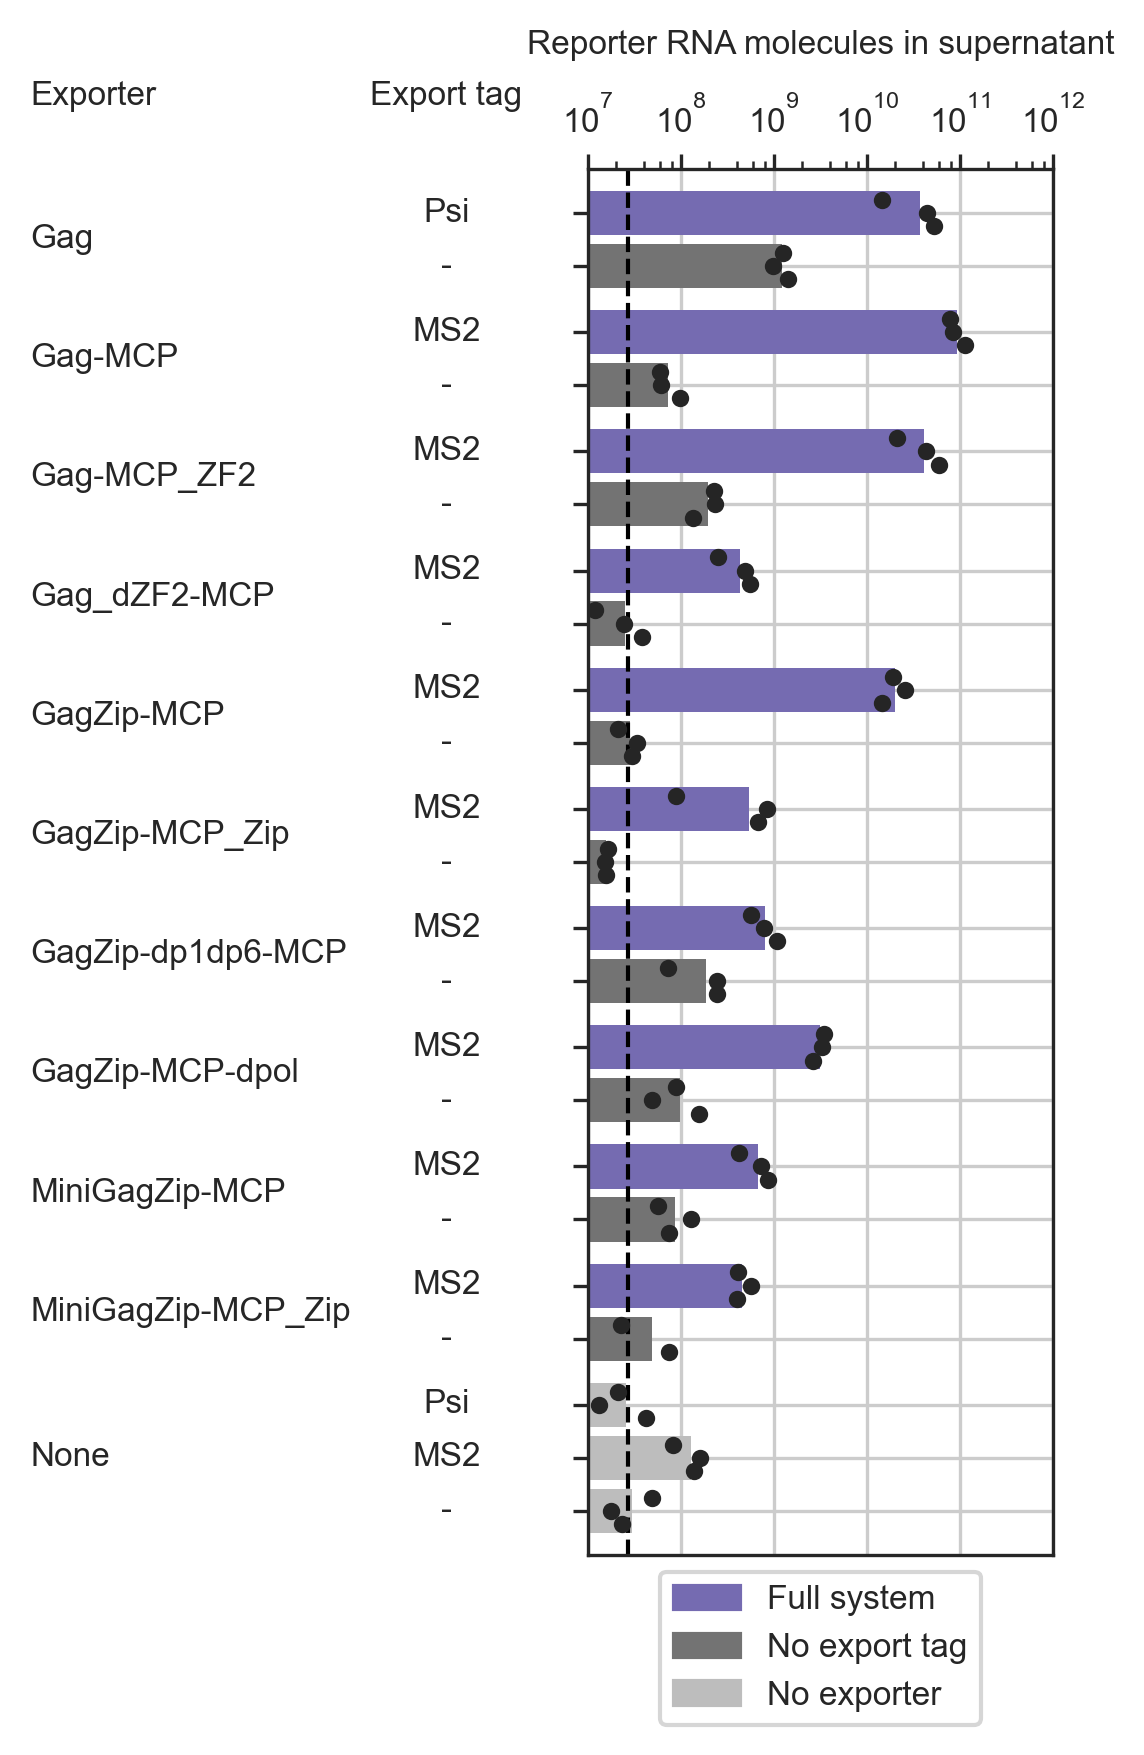

In [26]:
# Make simple plot that shows export using best system and comparison with wild-type Gag

field = "mean RNA molecules"

sns.set_style("ticks")

fig, ax = plt.subplots(1, 1, figsize=(2,6))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_xscale("log")
ax.set_xlim(1e7, 1e12)

# Get x positions of bars (numerical data)
x = summary_subset[field]

# Set colors
color = [column_to_color_simple[col] for col in columns_ordered]

# Specify custom y positions to group bars
y_origin = 0
y_offset = 0.3
y_space = 0.75

y = [y_origin+1*y_offset, y_origin+3*y_offset,
     y_origin+3*y_offset+y_space, y_origin+5*y_offset+y_space,
     y_origin+5*y_offset+2*y_space, y_origin+7*y_offset+2*y_space,
     y_origin+7*y_offset+3*y_space, y_origin+9*y_offset+3*y_space,
     y_origin+9*y_offset+4*y_space, y_origin+11*y_offset+4*y_space,
     y_origin+11*y_offset+5*y_space, y_origin+13*y_offset+5*y_space,
     y_origin+13*y_offset+6*y_space, y_origin+15*y_offset+6*y_space,
     y_origin+15*y_offset+7*y_space, y_origin+17*y_offset+7*y_space,
     y_origin+17*y_offset+8*y_space, y_origin+19*y_offset+8*y_space,
     y_origin+19*y_offset+9*y_space, y_origin+21*y_offset+9*y_space,
     y_origin+21*y_offset+10*y_space,
     y_origin+23*y_offset+10*y_space,
     y_origin+25*y_offset+10*y_space]
     
# Plot bars showing summary of replicates (mean)
ax.barh(y=y, width=x, color=color, height=0.5, linewidth=0)

# Plot individual points as swarm (sort columns appropriately)
sample_to_rank = dict(zip(columns_ordered, range(len(columns_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")
x_swarm = data["RNA molecules"]
y_swarm = np.array([y[rank] for rank in data["rank"]])
y_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
y_swarm_offset = y_swarm + np.tile(y_offset, int(len(y_swarm)/len(y_offset)))
ax.scatter(x_swarm, y_swarm_offset, color="#252525", s=10, zorder=10)

# Set axis aesthetics
ax.set_ylim(y[0]-0.5, y[-1]+0.5)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Reporter RNA molecules in supernatant", labelpad=10)
ax.set_ylabel("")
ax.set_yticks(y)
ax.grid(True)

# Set xticks
LIMIT_OF_DETECTION = summary.loc[("Supernatant", "Well24"), "mean RNA molecules"]
xticks = [LIMIT_OF_DETECTION, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12]
# ax.set_xticks(xticks)


locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Set custom tick labels
yticklabels = ""
ax.set_yticklabels(yticklabels, ha="left")

# Set custom tick text annotations
labels_exporter = [column_to_exporter[col] for col in columns_ordered][::2]
y_labels_exporter = [(y[0] + y[1])/2, 
                     (y[2] + y[3])/2, 
                     (y[4] + y[5])/2,
                     (y[6] + y[7])/2,
                     (y[8] + y[9])/2, 
                     (y[10] + y[11])/2,
                     (y[12] + y[13])/2,
                     (y[14] + y[15])/2,
                     (y[16] + y[17])/2,
                     (y[18] + y[19])/2,
                     (y[20] + y[21] + y[22])/3] 

x_pos_text_exporter = 0.1e2
x_pos_text_export_tag = 3e5

for label, y_pos in zip(labels_exporter, y_labels_exporter):
    ax.text(x_pos_text_exporter, y_pos, label, ha="left", va="center", size=FONTSIZE)

labels_reporter = [column_to_export_tag[col] for col in columns_ordered]
for label, y_pos in zip(labels_reporter, y):
    ax.text(x_pos_text_export_tag, y_pos, label, ha="center", va="center", size=FONTSIZE)

# Set tick annotation column labels
ax.text(x_pos_text_exporter, y[0]-1.5, "Exporter", ha="left", va="top", size=FONTSIZE)
ax.text(x_pos_text_export_tag, y[0]-1.5, "Export tag", ha="center", va="top", size=FONTSIZE)

# Add legend
color_legend = [color[0], color[2], color[1], color[-1]]
label_legend = ["Full system", "No export tag", "No exporter"]
patches = [mpl.patches.Patch(color=c) for c in color_legend]
ax.legend([patches[0], patches[2], patches[3]], label_legend,
          handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None)},
          loc="upper center", bbox_to_anchor=(0.5, 0))

# Draw line indicating limit of detection
ax.axvline(LIMIT_OF_DETECTION, ls="--", color="k", lw=1)

save_figure(fig, "barplot_VLP_screen")

# Visualize reporter RNA abundance in cells as barplot

In [27]:
# Choose samples
columns_ordered = ["Well5", "Well4",
                   "Well9", "Well8",
                   "Well11", "Well10",
                   "Well7", "Well6",
                   "Well13", "Well12",
                   "Well15", "Well14",
                   "Well17", "Well16",
                   "Well23", "Well22",
                   "Well19", "Well18",
                   "Well21", "Well20",
                   "Well1", "Well2", "Well3"]

In [28]:
# Select summary of samples
summary_subset = summary.loc["Cells"].loc[columns_ordered]

# Set label
summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(23, 5)


,mean SQ,std SQ,mean RNA molecules,std RNA molecules,label
Sample,,,,,
Well5,122813.378193,11805.229660,1.746049e+13,1.678360e+12,Both exporter and packaging signal
Well4,659173.971609,74761.327544,9.371534e+13,1.062888e+13,No packaging signal
Well9,127571.521557,6283.333386,1.709203e+13,8.418407e+11,Both exporter and packaging signal
Well8,318658.553410,16014.799075,8.866071e+12,4.455815e+11,No packaging signal
Well11,133097.217010,23832.839288,1.334182e+13,2.389032e+12,Both exporter and packaging signal
Well10,397259.762914,3700.155760,5.322485e+13,4.957467e+11,No packaging signal
Well7,150273.481219,9362.215320,2.382627e+13,1.484405e+12,Both exporter and packaging signal
Well6,484072.767945,57694.701374,5.664284e+13,6.751034e+12,No packaging signal
Well13,71072.444317,2381.531700,1.186474e+12,3.975697e+10,Both exporter and packaging signal


In [29]:
# Get data of technical replicates of selected samples
data = cq.loc["Cells"].loc[columns_ordered].reset_index()

print(data.shape)
data.head()

(69, 14)


,Sample,Well,Fluor,Target,Content,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Plate,RNA molecules
0,Well5,D05,SYBR,mCherry,Unkn-10,21.014294,20.922106,0.148889,115542.397236,5.062741,122813.378193,11805.229660,Plate1,1.642676e+13
1,Well5,E05,SYBR,mCherry,Unkn-10,21.001687,20.922106,0.148889,116463.225264,5.066189,122813.378193,11805.229660,Plate1,1.655768e+13
2,Well5,F05,SYBR,mCherry,Unkn-10,20.750338,20.922106,0.148889,136434.512078,5.134924,122813.378193,11805.229660,Plate1,1.939701e+13
3,Well4,D04,SYBR,mCherry,Unkn-08,18.409883,18.255502,0.177312,595604.753044,5.774958,659173.971609,74761.327544,Plate1,8.467765e+13
4,Well4,E04,SYBR,mCherry,Unkn-08,18.294777,18.255502,0.177312,640377.241107,5.806436,659173.971609,74761.327544,Plate1,9.104299e+13


In [ ]:
# Make simple plot that shows export using best system and comparison with wild-type Gag

field = "mean RNA molecules"

sns.set_style("ticks")

fig, ax = plt.subplots(1, 1, figsize=(2,6))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_xscale("log")
ax.set_xlim(1e11, 1e15)

# Get x positions of bars (numerical data)
x = summary_subset[field]

# Set colors
color = [column_to_color_simple[col] for col in columns_ordered]

# Specify custom y positions to group bars
y_origin = 0
y_offset = 0.3
y_space = 0.75

y = [y_origin+1*y_offset, y_origin+3*y_offset,
     y_origin+3*y_offset+y_space, y_origin+5*y_offset+y_space,
     y_origin+5*y_offset+2*y_space, y_origin+7*y_offset+2*y_space,
     y_origin+7*y_offset+3*y_space, y_origin+9*y_offset+3*y_space,
     y_origin+9*y_offset+4*y_space, y_origin+11*y_offset+4*y_space,
     y_origin+11*y_offset+5*y_space, y_origin+13*y_offset+5*y_space,
     y_origin+13*y_offset+6*y_space, y_origin+15*y_offset+6*y_space,
     y_origin+15*y_offset+7*y_space, y_origin+17*y_offset+7*y_space,
     y_origin+17*y_offset+8*y_space, y_origin+19*y_offset+8*y_space,
     y_origin+19*y_offset+9*y_space, y_origin+21*y_offset+9*y_space,
     y_origin+21*y_offset+10*y_space,
     y_origin+23*y_offset+10*y_space,
     y_origin+25*y_offset+10*y_space]
     
# Plot bars showing summary of replicates (mean)
ax.barh(y=y, width=x, color=color, height=0.5, linewidth=0)

# Plot individual points as swarm (sort columns appropriately)
sample_to_rank = dict(zip(columns_ordered, range(len(columns_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")
x_swarm = data["RNA molecules"]
y_swarm = np.array([y[rank] for rank in data["rank"]])
y_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
y_swarm_offset = y_swarm + np.tile(y_offset, int(len(y_swarm)/len(y_offset)))
ax.scatter(x_swarm, y_swarm_offset, color="#252525", s=10, zorder=10)

# Set axis aesthetics
ax.set_ylim(y[0]-0.5, y[-1]+0.5)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Reporter RNA molecules in cell RNA", labelpad=10)
ax.set_ylabel("")
ax.set_yticks(y)
ax.grid(True)

# Set xticks
LIMIT_OF_DETECTION = summary.loc[("Supernatant", "Well24"), "mean RNA molecules"]
xticks = [LIMIT_OF_DETECTION, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12]
# ax.set_xticks(xticks)


locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Set custom tick labels
yticklabels = ""
ax.set_yticklabels(yticklabels, ha="left")

# Set custom tick text annotations
labels_exporter = [column_to_exporter[col] for col in columns_ordered][::2]
y_labels_exporter = [(y[0] + y[1])/2, 
                     (y[2] + y[3])/2, 
                     (y[4] + y[5])/2,
                     (y[6] + y[7])/2,
                     (y[8] + y[9])/2, 
                     (y[10] + y[11])/2,
                     (y[12] + y[13])/2,
                     (y[14] + y[15])/2,
                     (y[16] + y[17])/2,
                     (y[18] + y[19])/2,
                     (y[20] + y[21] + y[22])/3] 

x_pos_text_exporter = 0.1e2
x_pos_text_export_tag = 3e9

# for label, y_pos in zip(labels_exporter, y_labels_exporter):
#     ax.text(x_pos_text_exporter, y_pos, label, ha="left", va="center", size=FONTSIZE)

labels_reporter = [column_to_export_tag[col] for col in columns_ordered]
for label, y_pos in zip(labels_reporter, y):
    ax.text(x_pos_text_export_tag, y_pos, label, ha="center", va="center", size=FONTSIZE)

# Set tick annotation column labels
# ax.text(x_pos_text_exporter, y[0]-1.5, "Exporter", ha="left", va="top", size=FONTSIZE)
ax.text(x_pos_text_export_tag, y[0]-1.5, "Export tag", ha="center", va="top", size=FONTSIZE)

# Add legend
color_legend = [color[0], color[2], color[1], color[-1]]
label_legend = ["Full system", "No export tag", "No exporter"]
patches = [mpl.patches.Patch(color=c) for c in color_legend]
ax.legend([patches[0], patches[2], patches[3]], label_legend,
          handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None)},
          loc="upper center", bbox_to_anchor=(0.5, 0))

# Draw line indicating limit of detection
ax.axvline(LIMIT_OF_DETECTION, ls="--", color="k", lw=1)

save_figure(fig, "barplot_VLP_screen_cells")

# Plot legend alone

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1,1))

color_legend = [color[0], color[2], color[1], color[-1]]
label_legend = ["Full system", "No export tag", "No exporter"]
patches = [mpl.patches.Patch(color=c) for c in color_legend]

ax.legend([patches[0], patches[2], patches[3]], label_legend,
          handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None)},
          loc="center", bbox_to_anchor=(0.5, 0))

plt.axis('off')

save_figure(fig, "barplot_legend")